In [1]:
import os
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

from scipy.stats import norm

# def matplotlib_theme_2_jupyter():
#     """
#     adapts plotting background to jupyter lab background
#     """
#     try: 
#         with open(f'/home/{os.getlogin()}/.jupyter/lab/user-settings/@jupyterlab/apputils-extension/themes.jupyterlab-settings') as file:
#             lines = file.readlines()
#             theme = [line.split(":")[1].split('"')[1] for line in lines if line.find('"theme"')>-1][0]
#     except:
#         theme = "JupyterLab Light"
#         print("Jupyter settings file was not found: modify the path above to your jupyter directory, or edit the colors manually")
#     if theme == 'JupyterLab Dark':
#         plt.style.use("dark_background")
#         plt.rcParams['figure.facecolor']=.07*np.ones(3)
#         plt.rcParams['figure.edgecolor']=.07*np.ones(3)
#         plt.rcParams['axes.facecolor']=.07*np.ones(3)  # set theme
#         plt.rcParams['grid.linewidth']=.2
#     else:
#         plt.style.use("default")       
# matplotlib_theme_2_jupyter()

import ipywidgets as widgets

## Setting safety-stock targets

This notebook summarizes some exploration of the paper 

### Acronyms
 - APS = advanced planning and scheduling
 - A/T = assembly and testing
 - CW = central warehosing
 - F/S = fabrication and sortyin
 - MEIO = multiechelon inventory optimization
 - MRP  = manufacturing resource planning
 - SFG = seminfinished goods
 - SKU = stock-keeping units
 - WOI = weeks of inventory



### Additional terminology

| Term                    | Symbol or equation |
|-------------------------|------------:|
| net replenishment  time |   $\tau$   |
| service level           |  $\alpha$  |
| expected safety stock target | $F^{-1}(\alpha)\sigma \sqrt{\tau}$ |
| demand in period $i$    | $D_i$ |
| forecast in period $i$  | $F_i$ |
| relative forecast accuracy| $\theta\triangleq \frac{F_i}{(F_i+D_i)}$ |



## Simple Monte-Carlo simulation of inventory levels

Let demand per period $D_i$ be normally distributed with mean $\mu$ and standard deviation $\sigma$

$$ D_i \sim \mathcal{N}(\mu,\sigma)$$

###  Demand rate distribution
The following cells shows a normal distribution (PDF and CDF) and the significance level, using `norm` class from `scipy.stats` module. The goal is just to illustrate the relationship of the significance level relative to the distribution


In [2]:
def show_demand( mu = 10, sigma=1.2, alpha_perc = 1):
    D_r = norm(mu, sigma)
    with plt.ioff():
        num="Demand distribution"
        if plt.fignum_exists(num):plt.close(num)
        fig,ax = plt.subplots(num=num)
        d_r = np.linspace(mu-4*sigma, mu+4*sigma, 100)
        
        ax.plot(d_r,D_r.pdf(d_r),color="C0")
        d_r_a = d_r[d_r<D_r.ppf(alpha_perc/100)]
        ax.fill_between(d_r_a, D_r.pdf(d_r_a),color="C0", alpha =.2)
        ax.set(xlabel="Demand rate $D_r$",ylabel="PDF",xlim=[d_r[0],d_r[-1]])
        bx = ax.twinx()
        bx.plot(d_r,D_r.cdf(d_r),color="C1")
        xl = bx.get_xlim()
        bx.plot([xl[1],D_r.ppf(alpha_perc/100)], np.ones(2)*alpha_perc/100,color="C1",ls="--")
        bx.text(xl[1],alpha_perc/100,f"$\\alpha$ = {alpha_perc/100:.2f} ",ha="right",va="bottom",color="C1")
        
        bx.set(ylabel="CDF",xlim=xl)
        fig.canvas.header_visible=False
        fig.canvas.toolbar_visible=False
        fig.canvas.show()
widgets.interact(show_demand,alpha_perc=widgets.IntSlider(min=1,max=99,step=1,value=15,continuous_update=False,description = "$\\alpha$ [%]"))

interactive(children=(IntSlider(value=10, description='mu', max=30, min=-10), FloatSlider(value=1.2, descripti…

<function __main__.show_demand(mu=10, sigma=1.2, alpha_perc=1)>

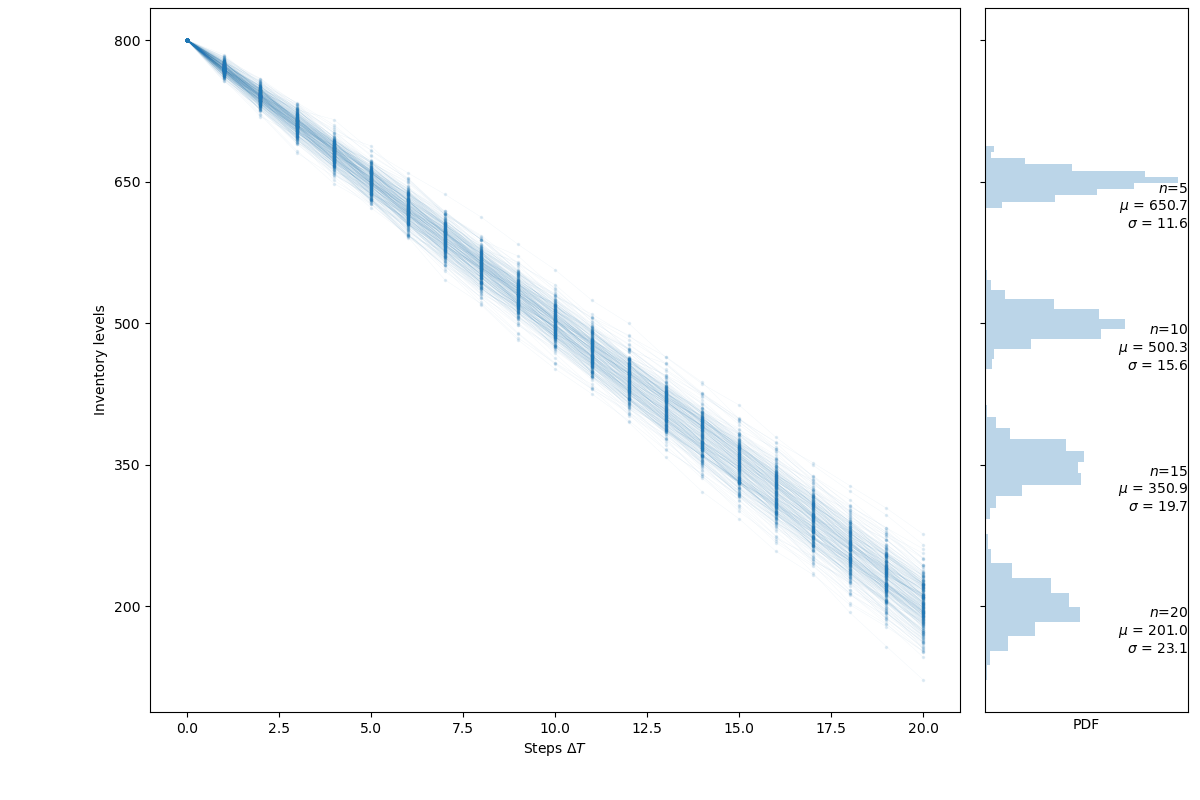

In [3]:
def simple_MC(N = 20, Lo = 800, mu = 30, sigma = 5, M = 300):
    """
    simple Monte-Carlo simulation of the invetory process
    
    Parameters
    ----------
    N  : int
         number of steps
    Lo : int
         initial inventory level
    mu : int or float
         mean of demand rate
    sigma : int or float
            standard deviation of demand rate
    M : int
        number of simulations
    """
    D = norm(mu,sigma)     # initiate demand rate distribution 
    Ls =np.zeros((N+1,M))  # initiate matrix for inventory levels
    ns = np.arange(N+1)
    for m in range(M):
        Ls[:,m] =  np.r_[Lo, Lo-D.rvs(N).cumsum()]  # np.random.randn(N)*sigma + mu
    with plt.ioff():
        num="MC stuff"
        if plt.fignum_exists(num):plt.close(num)
        fig,ax = plt.subplots(num=num, ncols=2, sharey=True, figsize=(12,8),
                              gridspec_kw=dict(width_ratios=[4,1], wspace=.05,top=.99,right=.99))
        ax[0].plot(ns,Ls,color="C0",alpha=.1,lw=.2,marker=".",markersize=3)

        ax[1].set(xticks=[], xlabel="PDF")
        step=N//4
        for n in np.arange(N,0,-step):
            ax[1].hist(Ls[n,:], bins = 10, density = True, orientation = "horizontal", alpha =.3, color="C0" )
        xl = ax[1].get_xlim()
        for n in np.arange(N,0,-step):
            ax[1].text(xl[1],Lo-n*mu,f"$n$={n}\n$\\mu$ = {Ls[n,:].mean():.1f}\n$\\sigma$ = {Ls[n,:].std():.1f}",ha="right",va="top")
            
        ax[0].set(xlabel="Steps $\Delta T$ ", ylabel="Inventory levels", xlim=[-1,N+1],
                  yticks=np.r_[Lo, Lo-np.arange(N,0,-step)*mu])
        fig.canvas.header_visible=False
        fig.canvas.toolbar_visible=False
        fig.canvas.show()    
simple_MC()   